# STAT 4770 Final Project - Vidur Saigal

### Understanding Factors Affecting Poor Health in US Counties

In this presentation, we explore a dataset of US counties and examine various health-related factors:

- We focus on the **Poor Health** outcome metric.
- We investigate relationships with obesity, physical inactivity, income, and more.
- We utilize data visualization, clustering, and modeling techniques (Decision Trees, Linear Regression) to gain insights.

Use the arrow keys to navigate through the slides!

In [1]:
# Imports and data loading (Setup Code)
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

file_path = 'project_4770_7770.csv'
data = pd.read_csv(file_path)

# Region assignment
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NY', 'PA', 'NJ'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    'South': ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV'],
    'West': ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']
}

data['Region'] = data['State.Abbreviation'].map(
    lambda x: next((k for k, v in regions.items() if x in v), 'Other')
)
data['Rural.Urban'] = data['Percent.Rural'].apply(lambda x: 'Rural' if x > 0.75 else 'Urban')

# Prepare modeling features
X = data[['Adult.Obesity', 'Physical.Inactivity', 'Median.Household.Income']]
y = data['Poor.Health']

tree_model = DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)
tree_model.fit(X, y)

tree_model_deep = DecisionTreeRegressor(max_leaf_nodes=30, random_state=42)
tree_model_deep.fit(X, y)
y_pred_tree = tree_model_deep.predict(X)
residuals_tree = y - y_pred_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_pred_reg = regression_model.predict(X_test)
residuals_reg = y_test - y_pred_reg


## Slide 1: Dataset Overview

**Purpose:** To understand the starting point of our analysis by reviewing the dataset structure and variables. This helps us confirm data availability and ensure the dataset is appropriate for exploring factors related to Poor Health.

In [2]:
print("Dataset Information:")
print(data.info())
print("\nFirst 5 Rows:")
display(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Row.Label                         2715 non-null   object 
 1   Five-digit.FIPS.Code              2715 non-null   int64  
 2   State.FIPS.Code                   2715 non-null   int64  
 3   County.FIPS.Code                  2715 non-null   int64  
 4   State.Abbreviation                2715 non-null   object 
 5   CountyName                        2715 non-null   object 
 6   Poor.Health                       2715 non-null   float64
 7   Election.Results.2016             2715 non-null   object 
 8   Uninsured                         2715 non-null   float64
 9   Primary.Care.Physicians.Per.1000  2715 non-null   float64
 10  Mental.health.providers.Per.1000  2715 non-null   float64
 11  Adult.Obesity                     2715 non-null 

,Row.Label,Five-digit.FIPS.Code,State.FIPS.Code,County.FIPS.Code,State.Abbreviation,CountyName,Poor.Health,Election.Results.2016,Uninsured,Primary.Care.Physicians.Per.1000,...,Unemployment,Food.Insecurity.Quintile,Income.Inequality.Quartile,Percent.Rural,Over.65,Percent.Females,Life.Expectancy,Population,Region,Rural.Urban
0,AL_Autauga County,1001,1,1,AL,Autauga County,0.1841,Republican,0.0850,0.415,...,0.0386,Q3,Q3,0.4200,0.151,0.513,76.330589,55504,South,Urban
1,AL_Baldwin County,1003,1,3,AL,Baldwin County,0.1806,Republican,0.1070,0.729,...,0.0399,Q3,Q3,0.4228,0.199,0.515,78.599498,212628,South,Urban
2,AL_Barbour County,1005,1,5,AL,Barbour County,0.2577,Republican,0.1251,0.385,...,0.0590,Q5,Q4,0.6779,0.188,0.472,75.779457,25270,South,Urban
3,AL_Bibb County,1007,1,7,AL,Bibb County,0.2000,Republican,0.0968,0.574,...,0.0439,Q4,Q2,0.6835,0.160,0.465,73.928271,22668,South,Urban
4,AL_Blount County,1009,1,9,AL,Blount County,0.2110,Republican,0.1211,0.225,...,0.0402,Q2,Q2,0.8995,0.178,0.507,74.597767,58013,South,Rural


**Conclusion:** The data is loaded successfully, with many columns relevant to health metrics and demographics. We have enough information to proceed with our analysis.

## Slide 2: Y-Variable Selection and Key Questions

**Purpose:** We select *Poor Health* as our key outcome measure. Understanding why this was chosen and what we hope to learn will guide our exploration.

Key Questions:
1. How does Median Household Income impact Poor Health?
2. Relationship between Physical Inactivity and Poor Health?
3. Relationship between Adult Obesity and Poor Health?
3. Are there regional differences in Poor Health?
4. Which predictors are most influential?

**Conclusion:** We have a clear target variable (Poor Health) and key questions guiding our analysis. The stage is set to delve deeper into the data and test these relationships.

## Slide 3: Distribution of Poor Health

**Purpose:** Examining the distribution of Poor Health across counties helps identify common levels, outliers, and the general shape of the outcome.

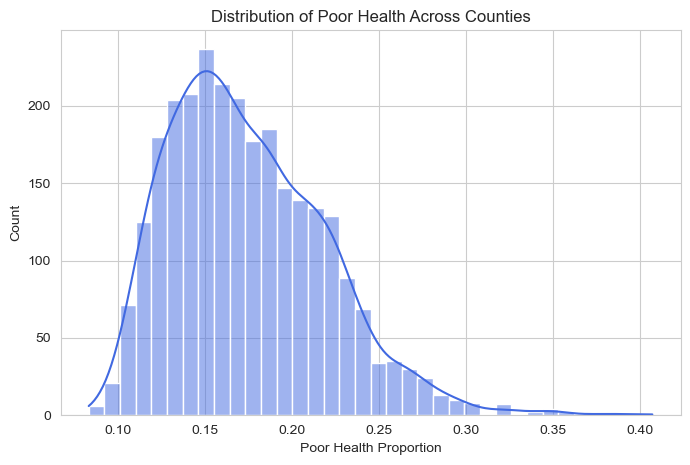

In [3]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Poor.Health'], kde=True, color='royalblue')
plt.title("Distribution of Poor Health Across Counties")
plt.xlabel("Poor Health Proportion")
plt.show()

**Conclusion:** Poor Health percentages vary but cluster within a certain range, with a relatively smooth distribution. There is a slight right skew.

## Slide 4: Boxplot of Poor Health by State

**Purpose:** A state-level view of Poor Health identifies geographic disparities and potential clusters of states with higher or lower Poor Health.

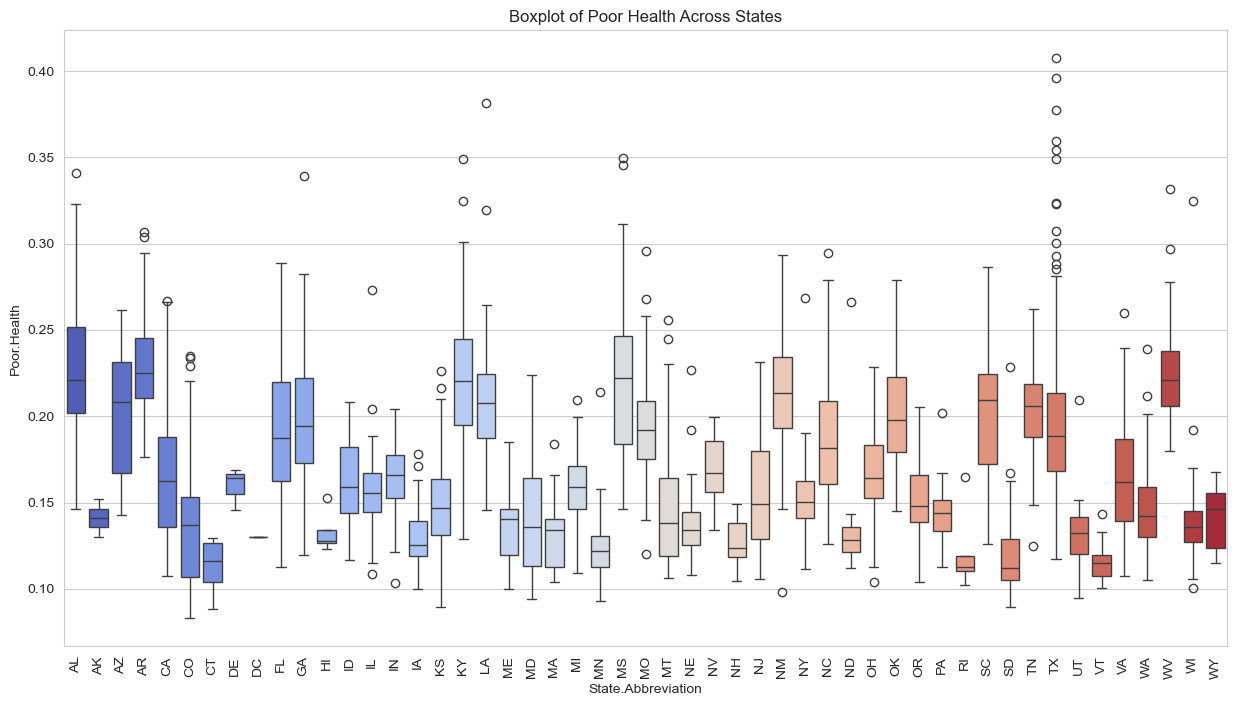

In [4]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="State.Abbreviation", hue="State.Abbreviation", y="Poor.Health", data=data, palette="coolwarm", legend=False)
plt.title("Boxplot of Poor Health Across States")
plt.xticks(rotation=90)
plt.show()

**Conclusion:** There's considerable variation in Poor Health across states. Some states consistently show higher median Poor Health levels, indicating region-specific issues that might warrant targeted interventions.

## Slide 5: Regional Comparisons of Poor Health

**Purpose:** By grouping states into regions, we can see if certain broad areas have higher Poor Health levels.

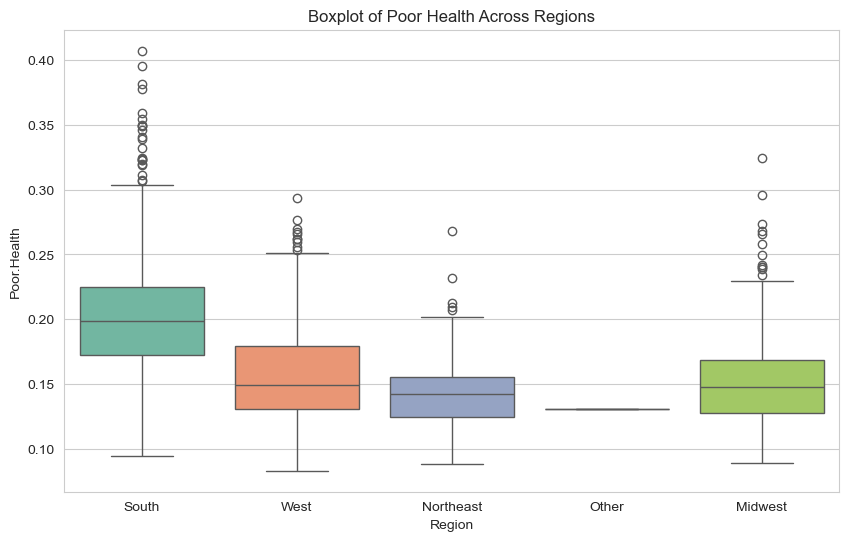

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(hue="Region", x="Region", y="Poor.Health", data=data, palette="Set2", legend=False)
plt.title("Boxplot of Poor Health Across Regions")
plt.show()

**Conclusion:** The South region exhibits noticeably higher levels of Poor Health on average compared to other regions, suggesting a need for region-specific policy or healthcare improvements there.

## Slide 6: Rural vs Urban Poor Health Comparison

**Purpose:** Comparing Poor Health in rural vs. urban counties shows if healthcare disparities align with population density.

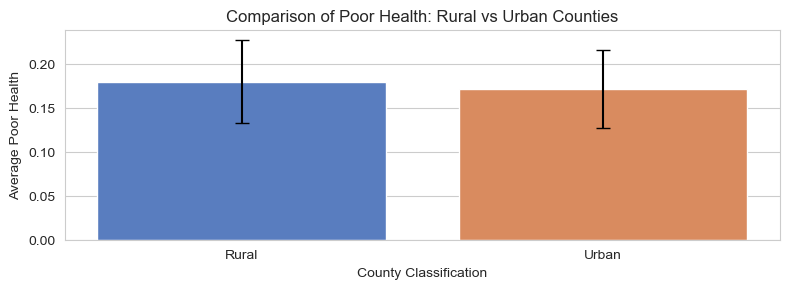

In [6]:
grouped_data = data.groupby('Rural.Urban')['Poor.Health'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(8, 3))
sns.barplot(hue='Rural.Urban', x='Rural.Urban', y='mean', data=grouped_data, palette='muted')
for i, row in grouped_data.iterrows():
    plt.errorbar(x=i, y=row['mean'], yerr=row['std'], fmt='none', color='black', capsize=5)
plt.title("Comparison of Poor Health: Rural vs Urban Counties")
plt.xlabel("County Classification")
plt.ylabel("Average Poor Health")
plt.xticks(ticks=[0, 1], labels=['Rural', 'Urban'])
plt.tight_layout()
plt.show()

**Conclusion:** Rural counties tend to have VERY slightly higher average Poor Health than urban counties, indicating possible access or lifestyle differences that could be influencing health outcomes. However, this difference seems to be within margin of error and not much should be drawn from this.

## Slide 7: Correlation Heatmap

**Purpose:** The correlation heatmap shows relationships between key predictors and Poor Health.

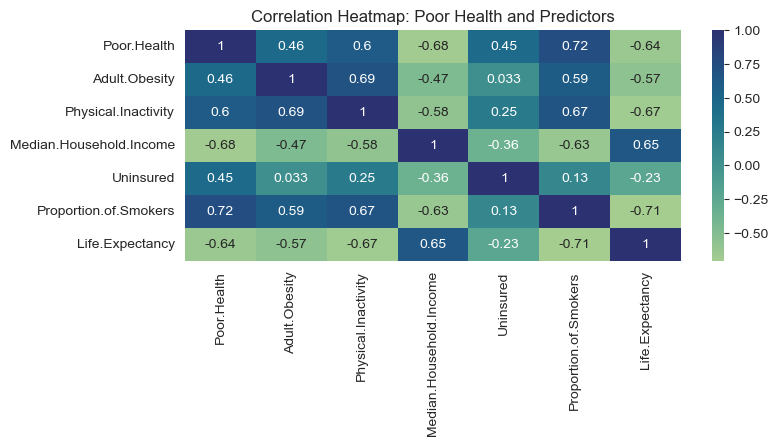

In [7]:
selected_columns = ['Poor.Health', 'Adult.Obesity', 'Physical.Inactivity', 
                    'Median.Household.Income', 'Uninsured', 'Proportion.of.Smokers', 'Life.Expectancy']
correlation_matrix = data[selected_columns].corr()

plt.figure(figsize=(8, 3))
sns.heatmap(correlation_matrix, annot=True, cmap="crest")
plt.title("Correlation Heatmap: Poor Health and Predictors")
plt.show()

**Conclusion:** Poor Health is positively correlated with obesity and physical inactivity, and negatively correlated with income and life expectancy. These patterns suggest lifestyle and economic factors are key.

## Slide 8: Obesity vs Poor Health

**Purpose:** Examining if higher obesity rates align with worse Poor Health.

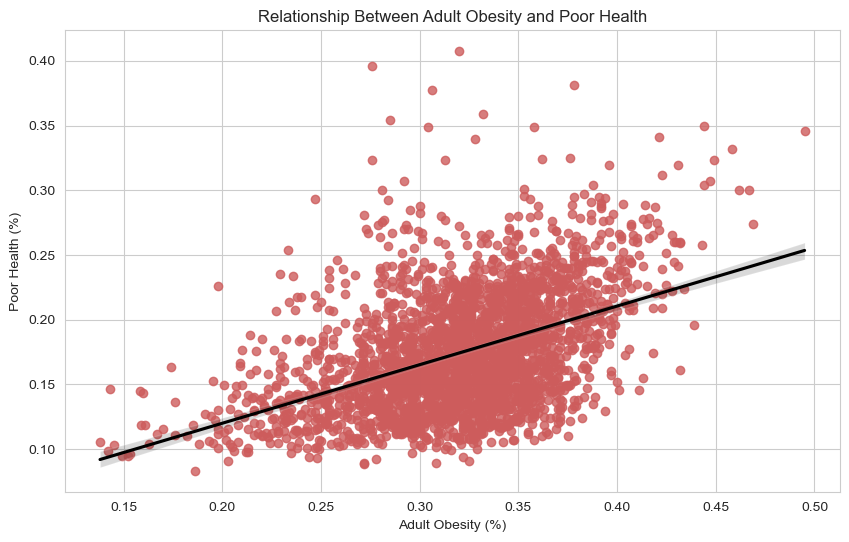

In [8]:
plt.figure(figsize=(10, 6))
sns.regplot(x="Adult.Obesity", y="Poor.Health", data=data,
            scatter_kws={"color": "indianred"}, line_kws={"color": "black"})
plt.title("Relationship Between Adult Obesity and Poor Health")
plt.xlabel("Adult Obesity (%)")
plt.ylabel("Poor Health (%)")
plt.show()

**Conclusion:** There is a clear positive trend: higher obesity percentages in a county generally correspond to higher Poor Health, reinforcing obesity as a critical factor.

## Slide 9: Physical Inactivity vs Poor Health

**Purpose:** Checking if inactivity relates to Poor Health.

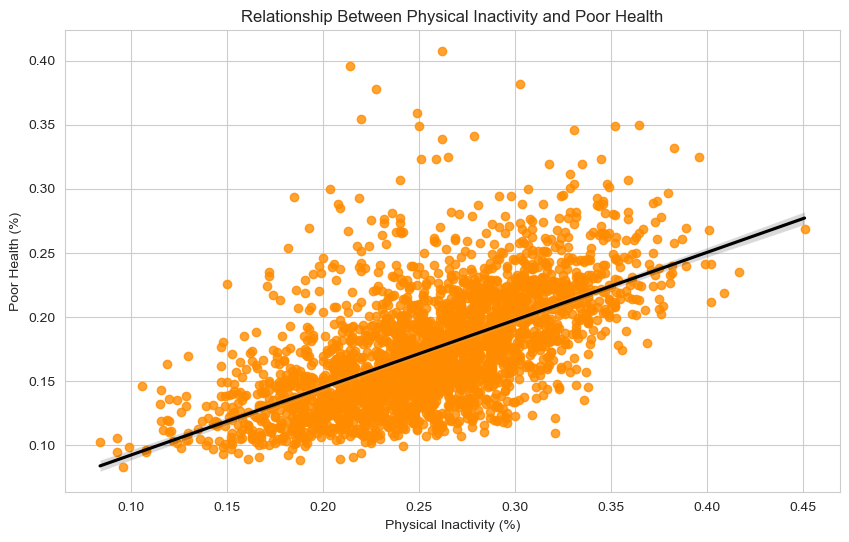

In [9]:
plt.figure(figsize=(10, 6))
sns.regplot(x="Physical.Inactivity", y="Poor.Health", data=data,
            scatter_kws={"color": "darkorange"}, line_kws={"color": "black"})
plt.title("Relationship Between Physical Inactivity and Poor Health")
plt.xlabel("Physical Inactivity (%)")
plt.ylabel("Poor Health (%)")
plt.show()

**Conclusion:** Similar to obesity, higher physical inactivity is associated with higher Poor Health levels, indicating that promoting active lifestyles might improve health outcomes.

## Slide 10: Income vs Poor Health

**Purpose:** Assessing how income relates to Poor Health.

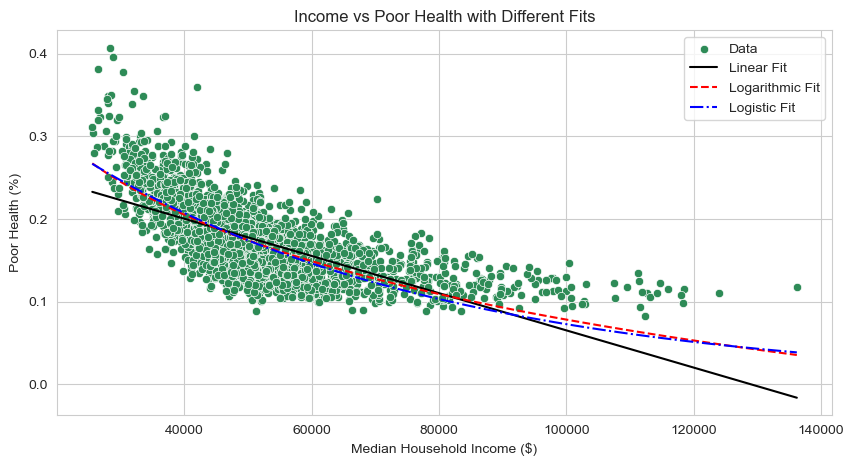

In [10]:
logistic = lambda x, L, k, x0: L / (1 + np.exp(-k * (x - x0)))
x, y, x_range = data['Median.Household.Income'], data['Poor.Health'], np.linspace(data['Median.Household.Income'].min(), data['Median.Household.Income'].max(), 100)
log_params, _ = curve_fit(logistic, x, y, p0=[y.max(), -0.0001, np.median(x)], maxfev=5000)
plt.figure(figsize=(10, 5)); sns.scatterplot(x=x, y=y, color="seagreen", label="Data")
plt.plot(x_range, np.poly1d(np.polyfit(x, y, 1))(x_range), color="black", label="Linear Fit")
plt.plot(x_range, np.poly1d(np.polyfit(np.log(x), y, 1))(np.log(x_range)), color="red", linestyle="--", label="Logarithmic Fit")
plt.plot(x_range, logistic(x_range, *log_params), color="blue", linestyle="-.", label="Logistic Fit")
plt.title("Income vs Poor Health with Different Fits"); plt.xlabel("Median Household Income ($)"); plt.ylabel("Poor Health (%)"); plt.legend(); plt.show()

**Conclusion:** Poor Health tends to decrease as median household income increases. Wealthier areas are generally healthier, indicating income-related disparities in healthcare access or lifestyle.

## Slide 11: Smoking vs Drinking

**Purpose:** See how smoking and drinking relate, and how Poor Health overlays.

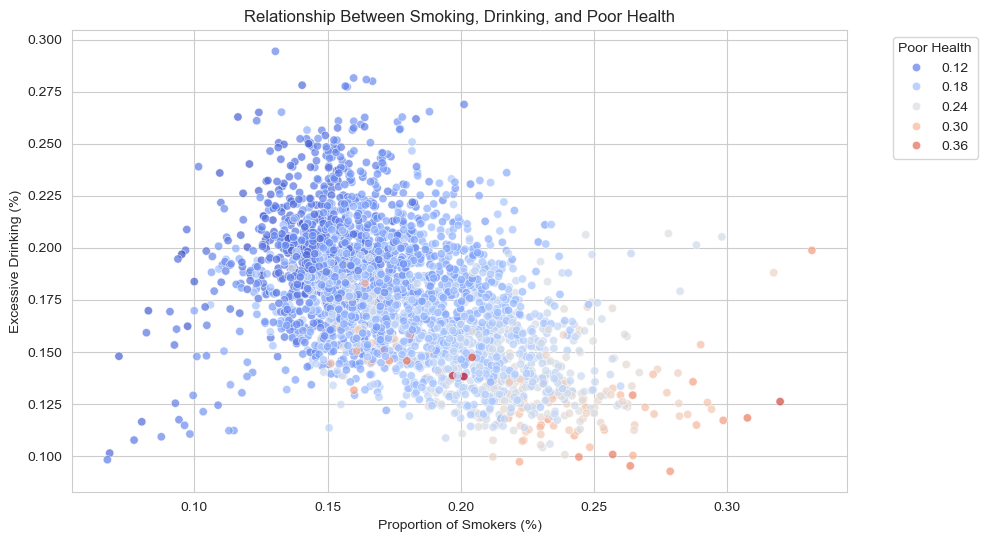

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Proportion.of.Smokers", y="Excessive.Drinking", hue="Poor.Health",
                data=data, palette="coolwarm", alpha=0.7)
plt.title("Relationship Between Smoking, Drinking, and Poor Health")
plt.xlabel("Proportion of Smokers (%)")
plt.ylabel("Excessive Drinking (%)")
plt.legend(title="Poor Health", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

**Conclusion:** Higher smoking and drinking rates often come with higher Poor Health values. However, this trend seems to be more prominant when looking at the proportion of smokers.

## Slide 12: State-Level Adult Obesity

**Purpose:** Comparing obesity rates by state.

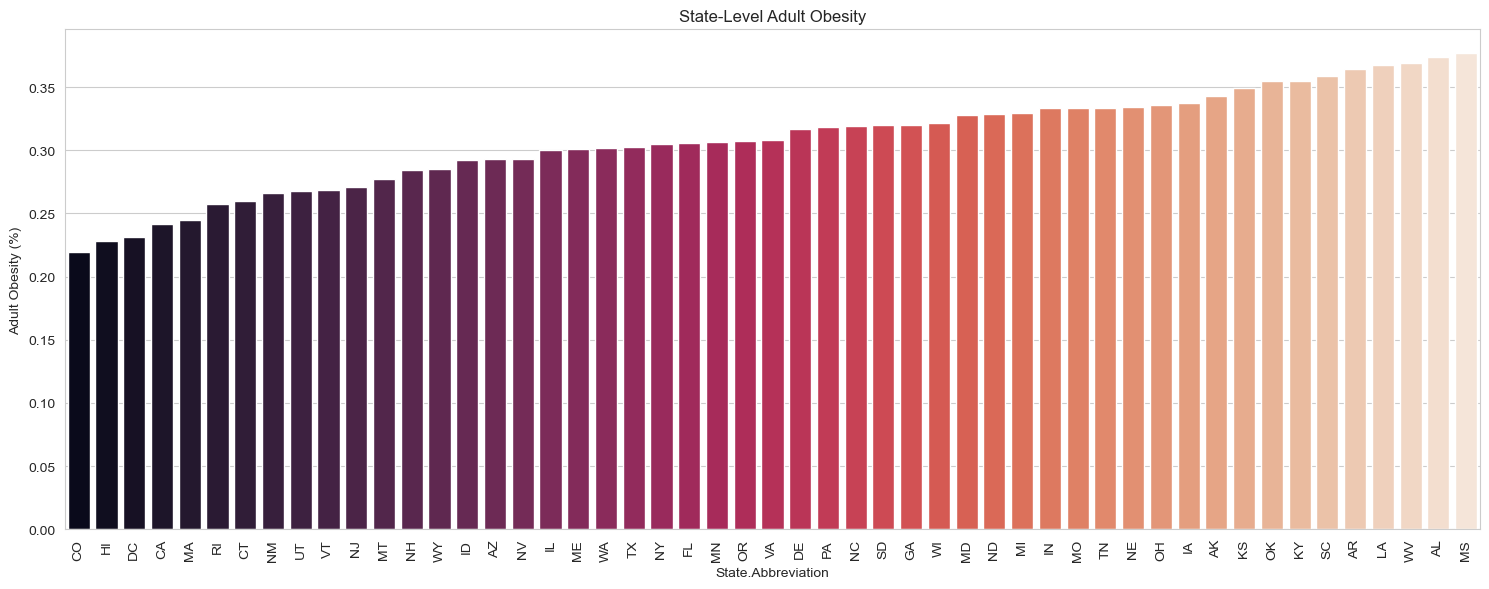

In [12]:
state_obesity = data.groupby("State.Abbreviation")['Adult.Obesity'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(hue="State.Abbreviation", x="State.Abbreviation", y="Adult.Obesity", 
            data=state_obesity.sort_values('Adult.Obesity'), palette="rocket", legend=False)
plt.title("State-Level Adult Obesity")
plt.xticks(rotation=90)
plt.ylabel("Adult Obesity (%)")
plt.tight_layout()
plt.show()

**Conclusion:** Some states have significantly higher obesity rates on average. Targeting these states with obesity-prevention programs could mitigate Poor Health issues.

## Slide 13: Pair Grid for High vs Low Poor Health

**Purpose:** Compare predictors in above- and below-median Poor Health groups.

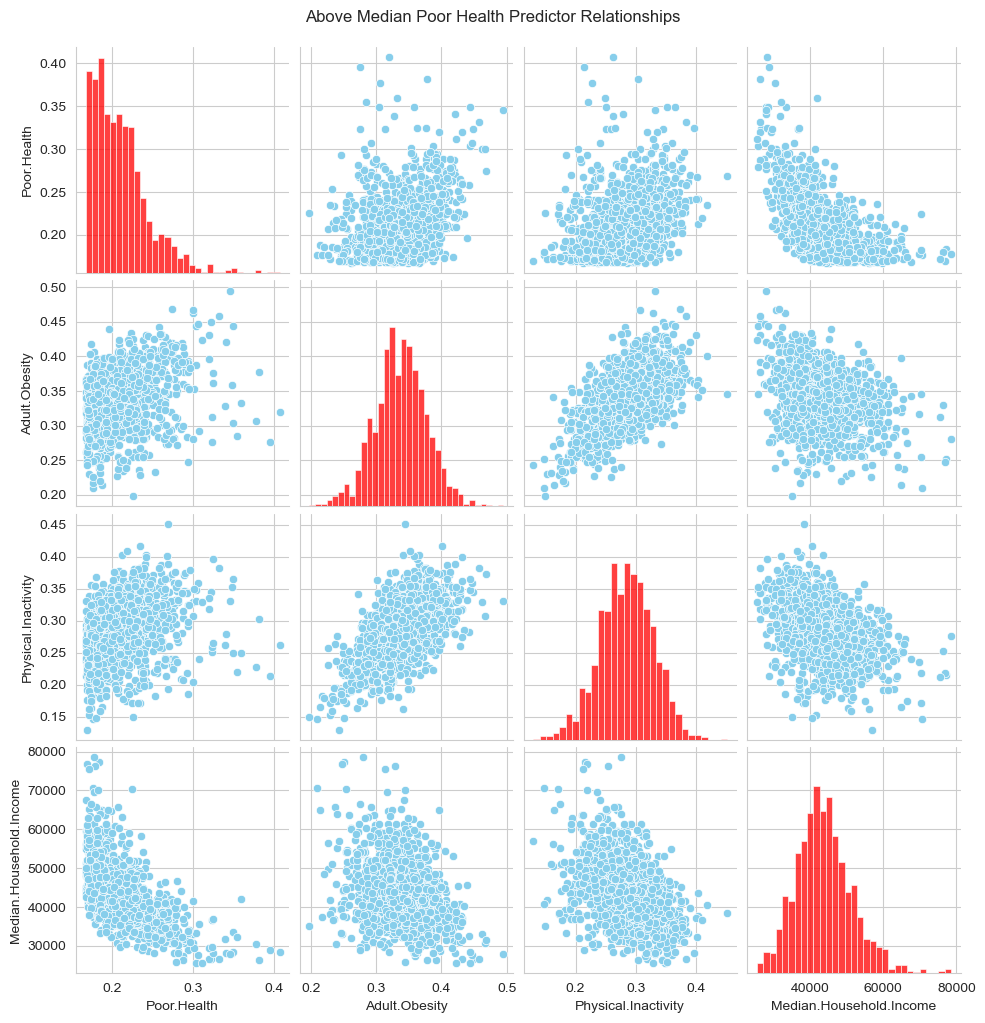

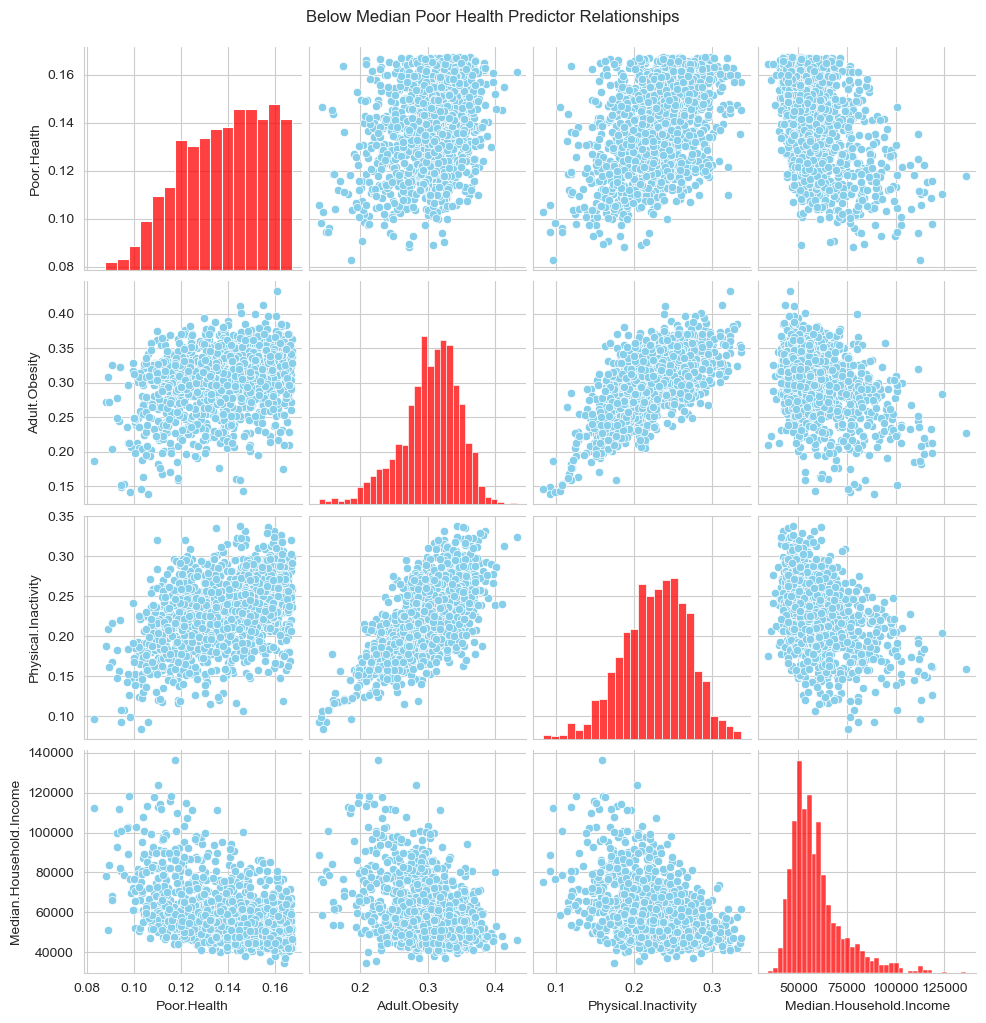

In [13]:
median_health = data['Poor.Health'].median()
high_health = data[data['Poor.Health'] > median_health]
low_health = data[data['Poor.Health'] <= median_health]

sns.pairplot(
    high_health[['Poor.Health', 'Adult.Obesity', 'Physical.Inactivity', 'Median.Household.Income']], 
    plot_kws={'color': 'skyblue'}, 
    diag_kws={'color': 'red'}
)
plt.suptitle("Above Median Poor Health Predictor Relationships", y=1.02)
plt.show()

sns.pairplot(
    low_health[['Poor.Health', 'Adult.Obesity', 'Physical.Inactivity', 'Median.Household.Income']], 
    plot_kws={'color': 'skyblue'}, 
    diag_kws={'color': 'red'}
)
plt.suptitle("Below Median Poor Health Predictor Relationships", y=1.02)
plt.show()

**Conclusion:** Counties with higher Poor Health tend to cluster with higher obesity and inactivity and lower income. Lower Poor Health counties show somewhat inverted patterns, highlighting the same key factors.

## Slide 14: Decision Tree Model

**Purpose:** Identify which variables and thresholds are most predictive of Poor Health.

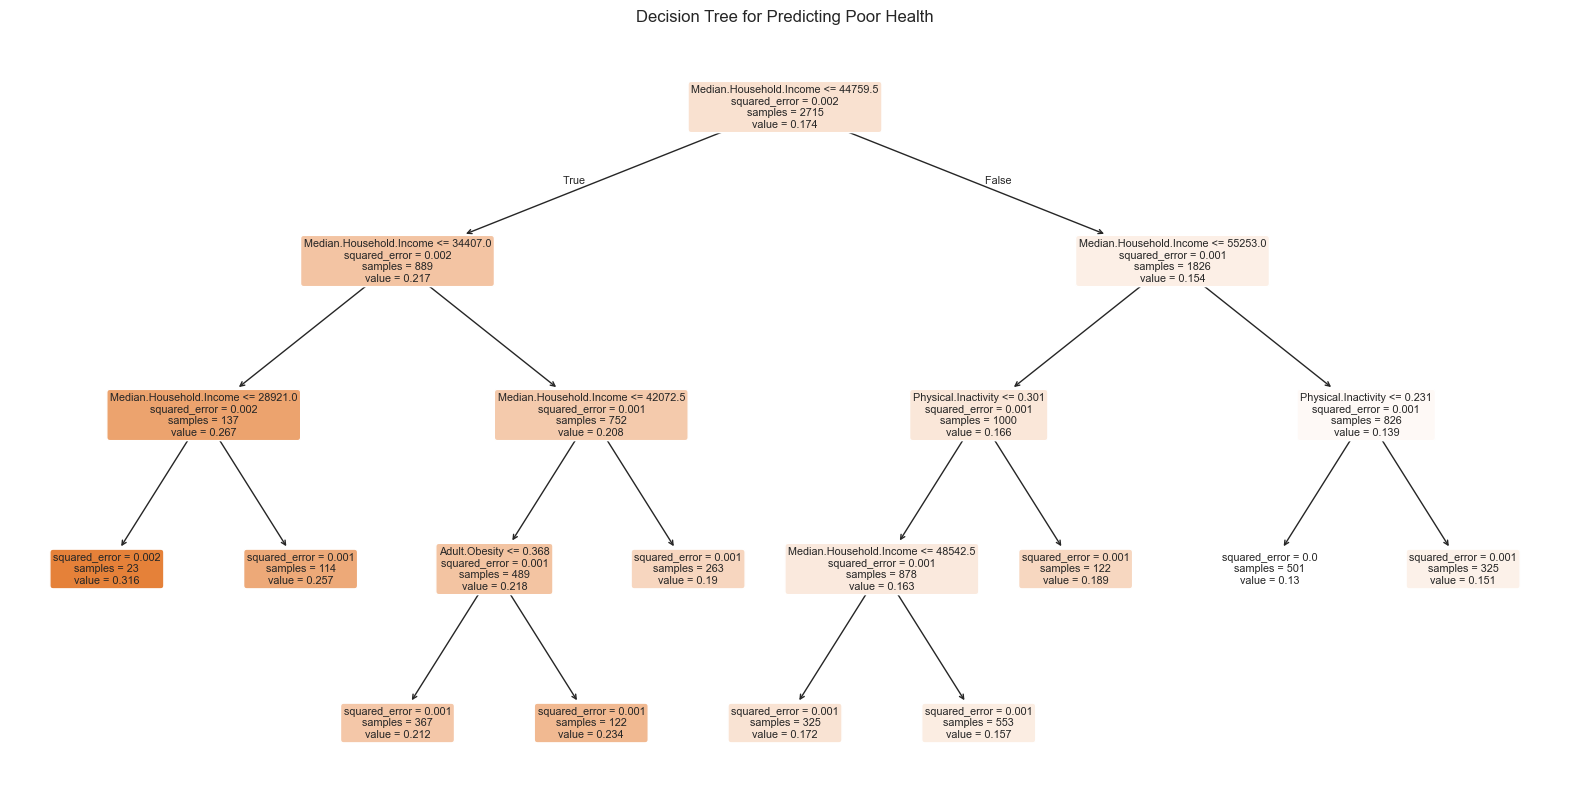

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree for Predicting Poor Health")
plt.show()

**Conclusion:** The tree splits primarily on Income first, suggesting this to be the key first-step predictors. Obesity and Physical Inactivity also appears down the branches, indicating a secondary but important role.

## Slide 15: Feature Importance from Decision Tree

**Purpose:** Rank features by how often they are used in the tree.

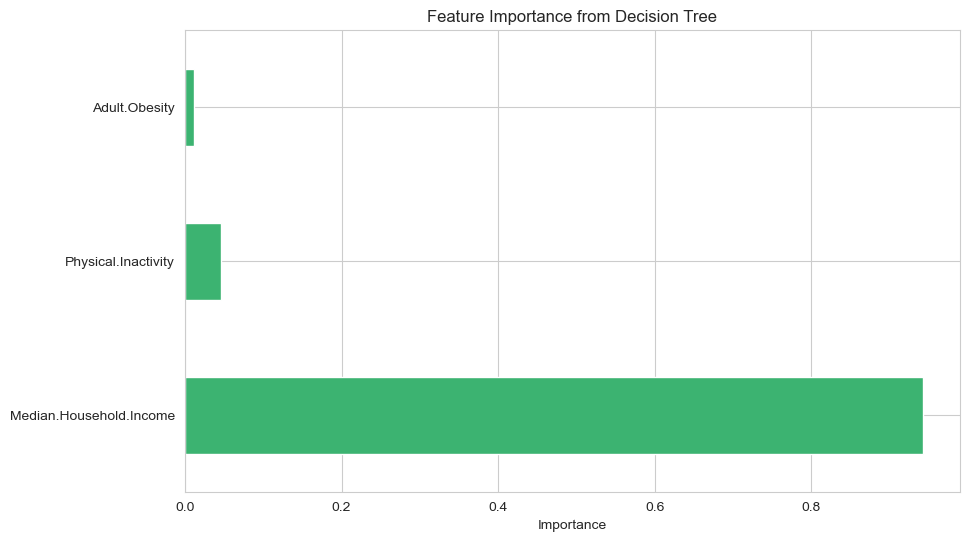

In [15]:
importances = pd.Series(tree_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='barh', color='mediumseagreen')
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Importance")
plt.show()

**Conclusion:** Median Household Income is the most important predictor, followed by Physical Inactivity and then Obesity. This ranking aligns with our earlier correlations and confirms their significance.

## Slide 16: Deep Decision Tree with 30 Nodes

**Purpose:** Explore a more complex tree structure.

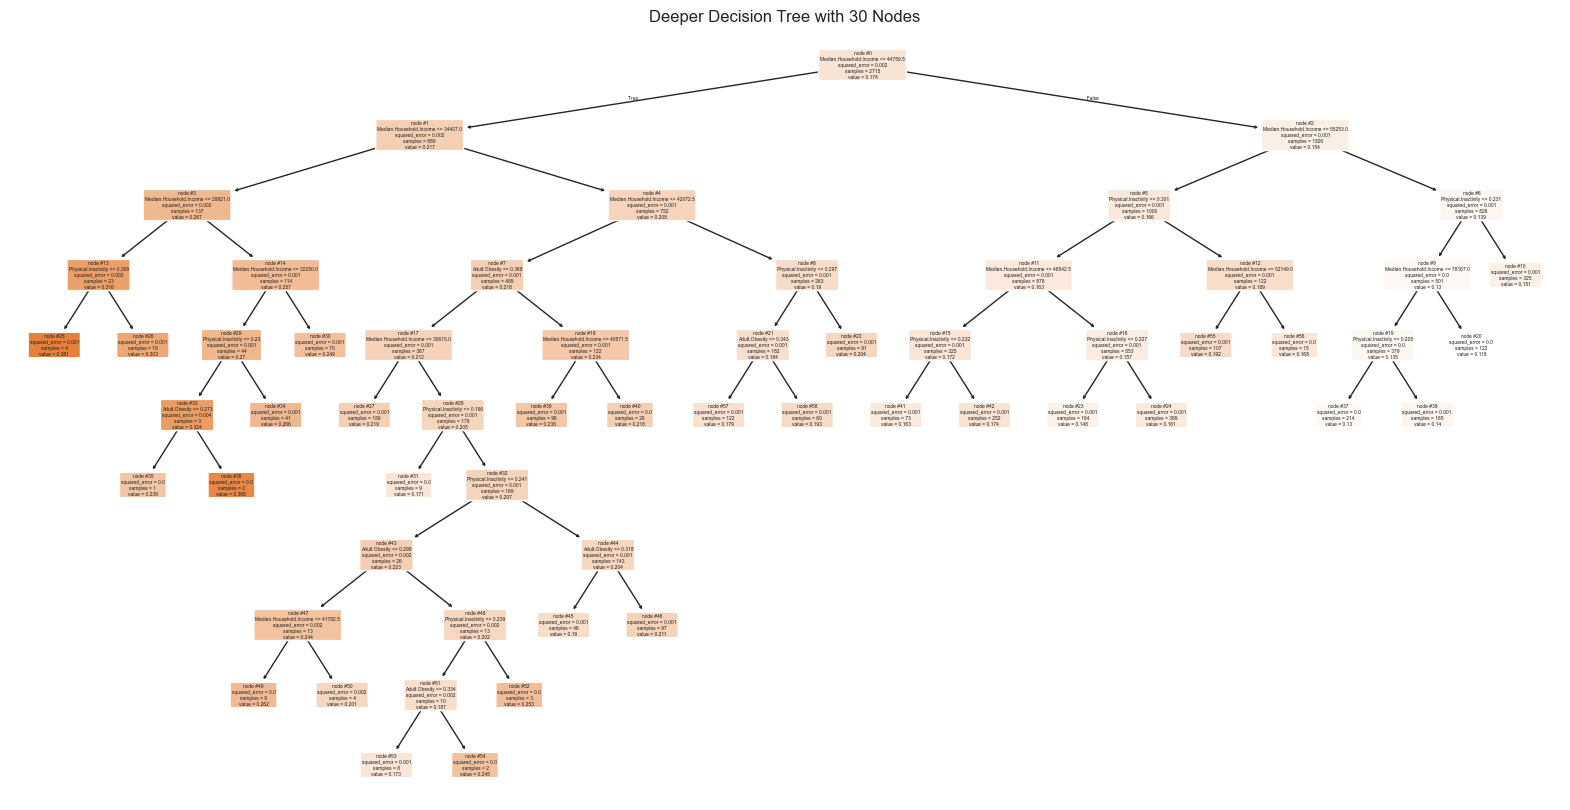

In [16]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model_deep, feature_names=X.columns, filled=True, rounded=True, node_ids=True)
plt.title("Deeper Decision Tree with 30 Nodes")
plt.show()

**Conclusion:** The deeper tree may fit more nuances but risks overfitting. It still emphasizes income splits, indicating the complexity comes from finer distinctions rather than changing the main predictors.

## Slide 17: Residual Plot for Decision Tree

**Purpose:** Check model fit by examining residuals.

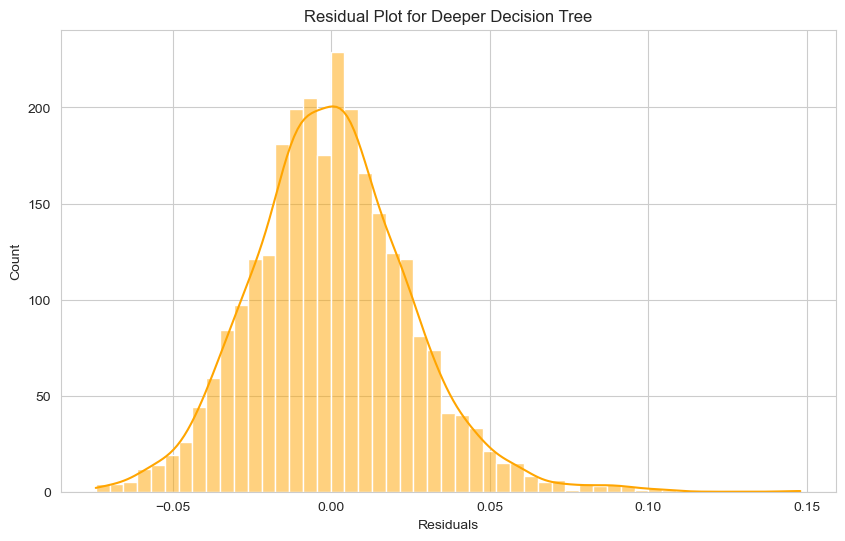

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals_tree, kde=True, color="orange")
plt.title("Residual Plot for Deeper Decision Tree")
plt.xlabel("Residuals")
plt.show()

**Conclusion:** Residuals appear roughly centered around zero and is almost perfectly symmetric. The model does reasonably well.

## Slide 18: K-Means Clustering on Midwest Counties

**Purpose:** Group Midwest counties based on obesity, inactivity, income.

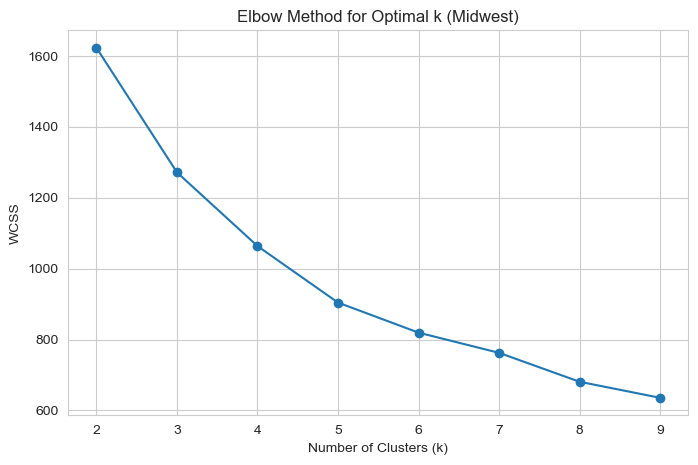

In [18]:
midwest_data=data[data['Region']=='Midwest'].copy(); cluster_features=['Adult.Obesity','Physical.Inactivity','Median.Household.Income']; cluster_data=StandardScaler().fit_transform(midwest_data[cluster_features]); wcss=[KMeans(n_clusters=k,random_state=42).fit(cluster_data).inertia_ for k in range(2,10)]; plt.figure(figsize=(8,5)); plt.plot(range(2,10),wcss,marker='o'); plt.title('Elbow Method for Optimal k (Midwest)'); plt.xlabel('Number of Clusters (k)'); plt.ylabel('WCSS'); plt.show()

**Conclusion:** The elbow method suggests around k=5 clusters might be optimal, balancing complexity and interpretability.

## Slide 19: Choosing the Optimal Number of Clusters (Midwest)

**Purpose:** Using k=5 to examine cluster shapes and distributions.

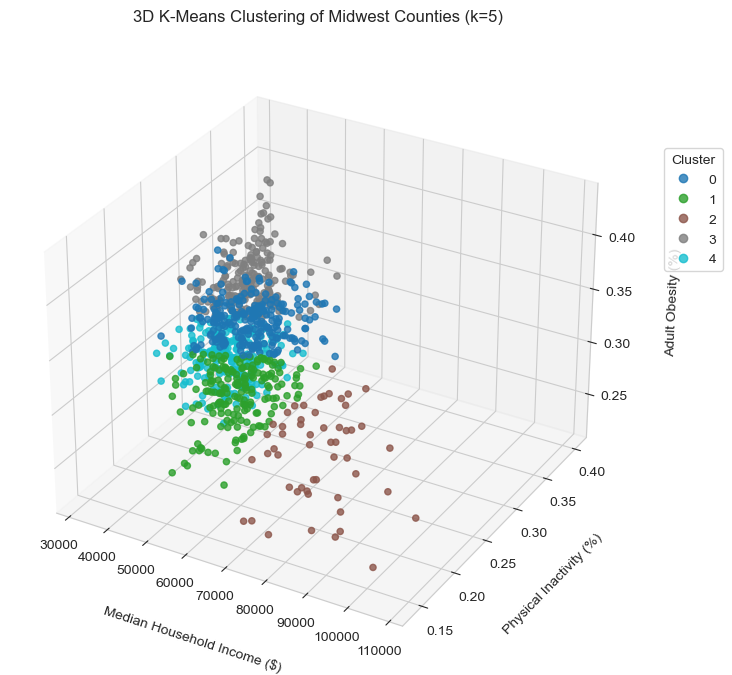

In [19]:
optimal_k=5; kmeans=KMeans(n_clusters=optimal_k, random_state=42); midwest_data['Cluster']=kmeans.fit_predict(cluster_data); fig=plt.figure(figsize=(12,8)); ax=fig.add_subplot(111, projection='3d'); scatter=ax.scatter(midwest_data['Median.Household.Income'],midwest_data['Physical.Inactivity'],midwest_data['Adult.Obesity'],c=midwest_data['Cluster'],cmap="tab10",alpha=0.8); ax.set_title(f"3D K-Means Clustering of Midwest Counties (k={optimal_k})",pad=20); ax.set_xlabel("Median Household Income ($)",labelpad=15); ax.set_ylabel("Physical Inactivity (%)",labelpad=15); ax.set_zlabel("Adult Obesity (%)",labelpad=15); plt.legend(*scatter.legend_elements(),title="Cluster",loc="upper left",bbox_to_anchor=(1.05,0.85)); plt.show()

**Conclusion:** Counties form distinct groups based on their income, obesity, and inactivity profiles. Some clusters represent wealthier, healthier counties, while others group lower-income, higher-obesity communities.

## Slide 20: Poor Health Across Midwest Clusters

**Purpose:** Compare Poor Health levels within each cluster.

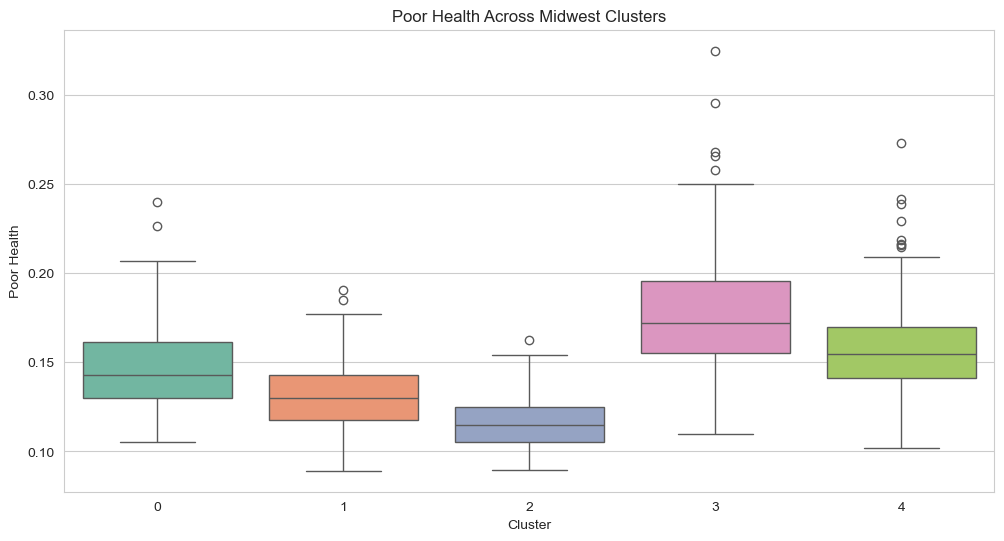

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(hue="Cluster", x="Cluster", y="Poor.Health", data=midwest_data, palette="Set2", legend=False)
plt.title("Poor Health Across Midwest Clusters")
plt.xlabel("Cluster")
plt.ylabel("Poor Health")
plt.show()

**Conclusion:** Clusters with lower average income and higher obesity/inactivity also show higher Poor Health. Clusters representing more affluent, active counties display better health profiles.

## Slide 21: State-Level Physical Inactivity

**Purpose:** Identify states with higher inactivity.

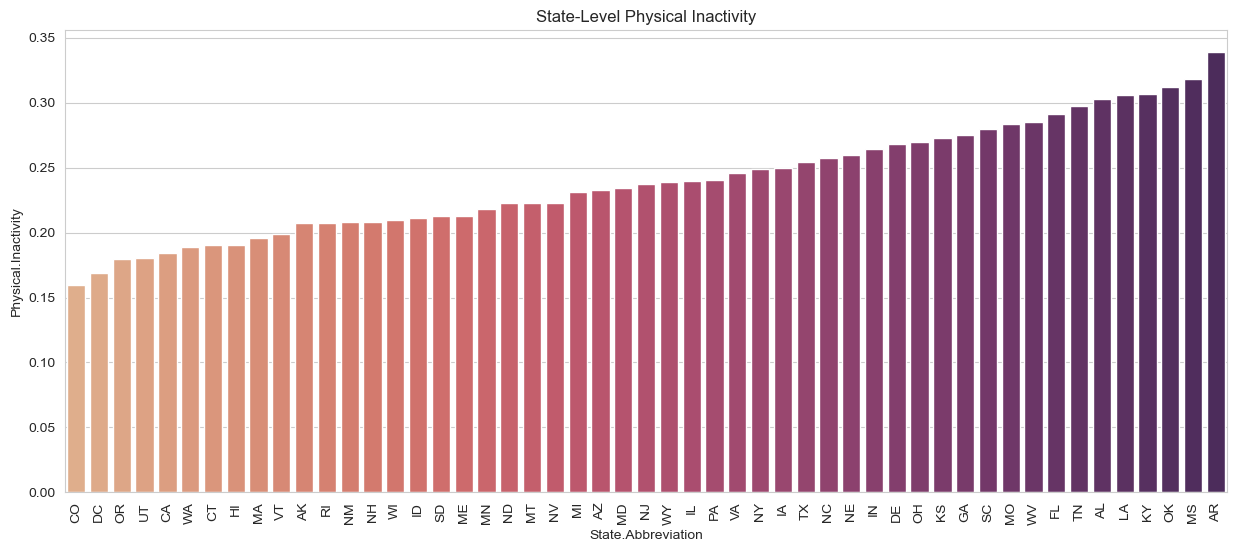

In [21]:
state_inactivity = data.groupby("State.Abbreviation")['Physical.Inactivity'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(hue="State.Abbreviation", x="State.Abbreviation", y="Physical.Inactivity", 
            data=state_inactivity.sort_values('Physical.Inactivity'), palette="flare", legend=False)
plt.title("State-Level Physical Inactivity")
plt.xticks(rotation=90)
plt.show()

**Conclusion:** Some states stand out with higher inactivity rates, indicating potential targets for campaigns encouraging active living to improve health outcomes.

## Slide 22: Uninsured vs Poor Health

**Purpose:** Assess how insurance coverage relates to Poor Health.

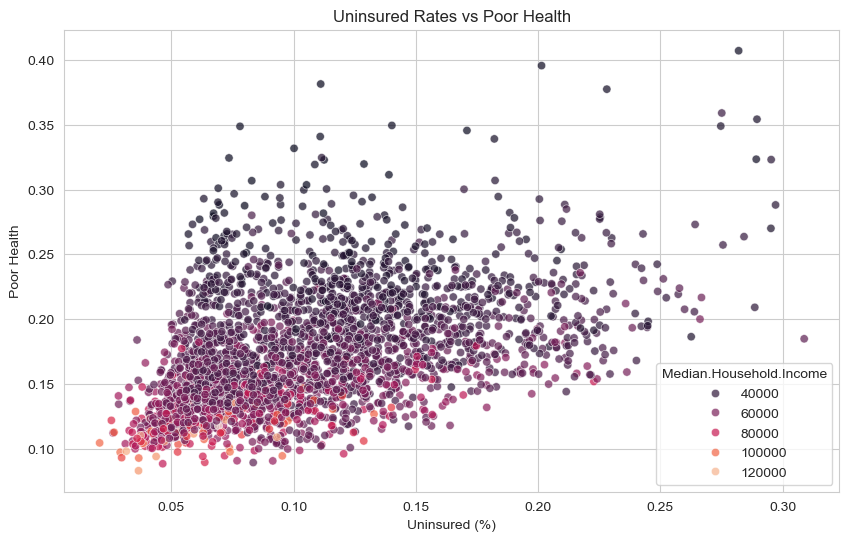

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Uninsured", y="Poor.Health", hue="Median.Household.Income", data=data, palette="rocket", alpha=0.7)
plt.title("Uninsured Rates vs Poor Health")
plt.xlabel("Uninsured (%)")
plt.ylabel("Poor Health")
plt.show()

**Conclusion:** Counties with higher uninsured rates often correlate with higher Poor Health, especially if coupled with lower incomes. Improving insurance coverage could mitigate poor health conditions.

## Slide 23: Comparison of Regions for Key Predictors

**Purpose:** Compare average obesity, inactivity, and poor health by region.

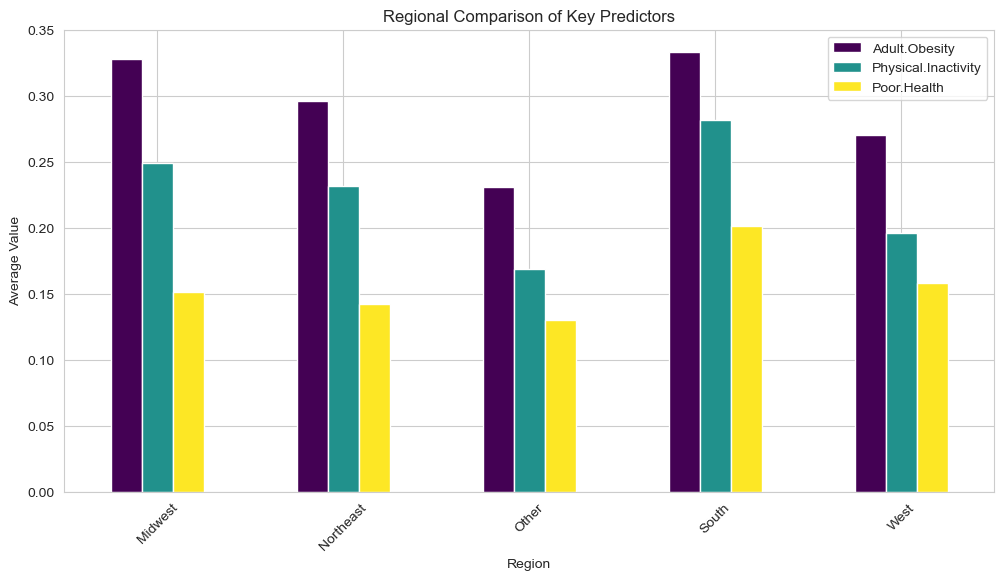

In [23]:
regional_means = data.groupby("Region")[['Adult.Obesity', 'Physical.Inactivity', 'Poor.Health']].mean()
regional_means.plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Regional Comparison of Key Predictors")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.show()

**Conclusion:** The South tends to have higher obesity, inactivity, and poor health compared to other regions, reinforcing earlier findings that it is a hotspot for health challenges.

## Slide 24: Strip Plot of Poor Health vs County Type

**Purpose:** Visualize Poor Health distribution by region and rural/urban classification.

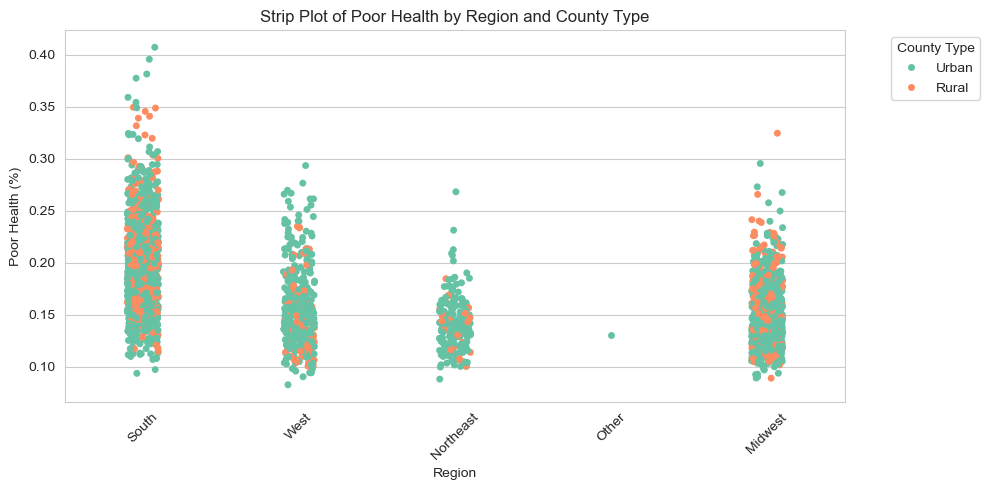

In [24]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="Region", y="Poor.Health", hue="Rural.Urban", data=data, palette="Set2")
plt.title("Strip Plot of Poor Health by Region and County Type")
plt.xlabel("Region")
plt.ylabel("Poor Health (%)")
plt.xticks(rotation=45)
plt.legend(title="County Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Conclusion:** Rural and Urban counties in the South region often appear to have the highest Poor Health rates. Again, we see that there is not much of a clear difference between Urban and Rural counties.

## Slide 25: Stacked Bar Chart of Poor Health Distribution by Region

**Purpose:** Show how poor health levels (low, medium, high) distribute across regions.

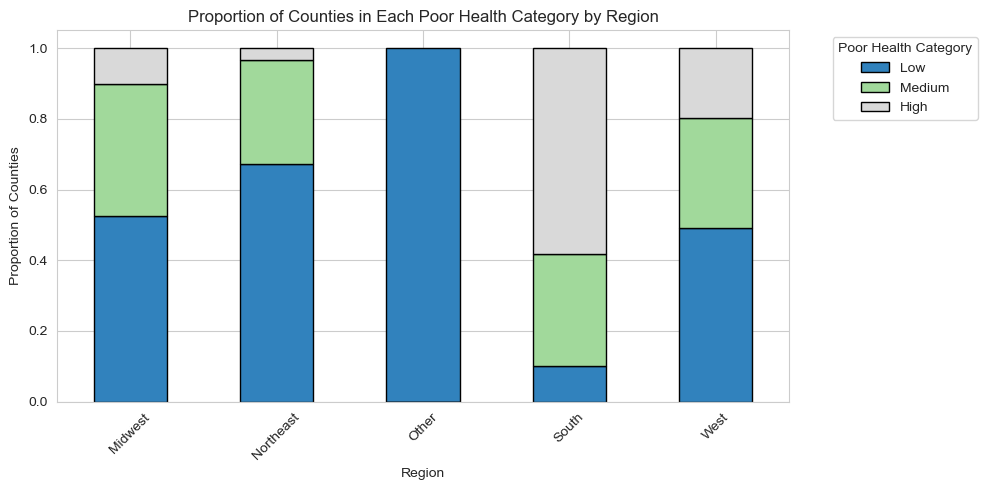

In [25]:
data['Poor_Health_Tercile'] = pd.qcut(data['Poor.Health'], q=3, labels=['Low', 'Medium', 'High'])
counts = data.groupby(['Region', 'Poor_Health_Tercile'], observed=False).size().unstack(fill_value=0)
props = counts.div(counts.sum(axis=1), axis=0)
props.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20c', edgecolor='black')
plt.title("Proportion of Counties in Each Poor Health Category by Region"); plt.xlabel("Region"); plt.ylabel("Proportion of Counties") ;plt.xticks(rotation=45); plt.legend(title="Poor Health Category", bbox_to_anchor=(1.05, 1), loc='upper left'); plt.tight_layout()
plt.show()

**Conclusion:** The South has a higher proportion of counties in the 'High' Poor Health category, further confirming that the region consistently struggles with poorer health outcomes.

## Slide 26: Decision Tree vs Linear Regression Comparison

**Purpose:** Compare model errors to gauge which model fits better.

In [26]:
mse_tree = mean_squared_error(y, y_pred_tree)
mse_reg = mean_squared_error(y_test, y_pred_reg)
print(f"Mean Squared Error (Decision Tree): {mse_tree:.4f}")
print(f"Mean Squared Error (Linear Regression): {mse_reg:.4f}")

Mean Squared Error (Decision Tree): 0.0006
Mean Squared Error (Linear Regression): 0.0009


**Conclusion:** The decision tree may fit the training data better, but both models seem to fit the data very well. 

## Slide 27: Violin Plot - Poor Health vs Median Household Income

**Purpose:** Examine Poor Health distributions across income quartiles.

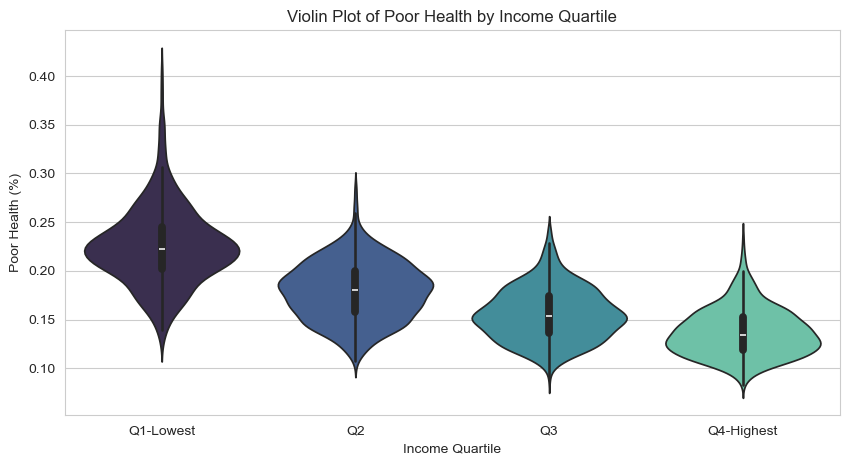

In [27]:
data['Income_Quartile'] = pd.qcut(data['Median.Household.Income'], q=4, labels=['Q1-Lowest', 'Q2', 'Q3', 'Q4-Highest'])
plt.figure(figsize=(10,5))
sns.violinplot(hue='Income_Quartile', x='Income_Quartile', y='Poor.Health', data=data, palette='mako')
plt.title("Violin Plot of Poor Health by Income Quartile")
plt.xlabel("Income Quartile"); plt.ylabel("Poor Health (%)")
plt.show()

**Conclusion:** Lower income quartiles have higher and more spread-out Poor Health distributions. Higher-income counties cluster at lower Poor Health values, supporting the income-health link.

## Slide 28: Subgroup Analysis for South Region

**Purpose:** Focus on Southern states' Poor Health.

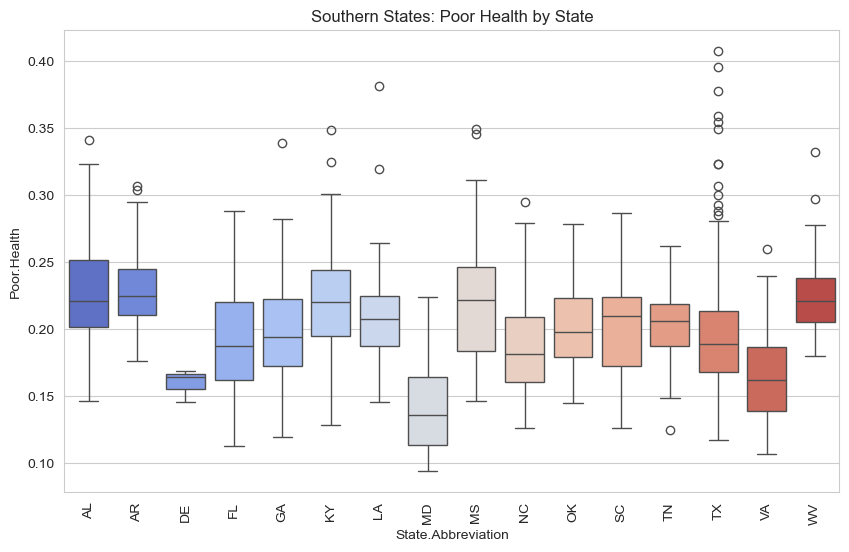

In [28]:
south_region = data[data['Region'] == "South"]
plt.figure(figsize=(10, 6))
sns.boxplot(hue="State.Abbreviation", x="State.Abbreviation", y="Poor.Health", data=south_region, palette="coolwarm", legend=False)
plt.title("Southern States: Poor Health by State")
plt.xticks(rotation=90)
plt.show()

**Conclusion:** Within the South, certain states stand out as having particularly high Poor Health. This granularity helps pinpoint which states might need the most focused interventions.

## Slide 29: Final Summary of Findings

**Purpose:** Summarize insights into actionable takeaways.

- Obesity and Physical Inactivity strongly correlate with Poor Health.
- The South region shows significantly higher Poor Health.
- Income is an extremely critical factor driving poor health outcomes.

**Conclusion:** Some key drivers of Poor Health are lifestyle factors (obesity, inactivity) and socioeconomic factors (income), with distinct regional patterns, especially in the South.

## Slide 30: Recommendations

**Purpose:** Turn insights into practical guidance.

- Target interventions in southern counties.
- Focus on reducing physical inactivity and obesity.
- Improve healthcare access for the uninsured.
- Use predictive models for efficient resource allocation.

**Conclusion:** By focusing on socioeconomic and lifestyle interventions, especially in high-risk regions, policymakers can potentially improve the population's health outcomes.